## Redes Neuronales - Parte I

En esta actividad vamos a aprender a desarrollar nuestra propia red neuronal para reconocimiento de imagenes.

Para ello, vamos a trabajar con un dataset (digits.csv) que contiene imagenes en escala de grises de 28x28 pixeles (un total de 784 pixeles). Cada imagen representa un digito (desde el 0 al 9) escrito a mano. Cada pixel tiene un valor asociado entre 0 y 255 que indica la luminosidad u oscuridad de dicho pixel (valores mas grandes indican mayor oscuridad).

El dataset tiene 785 columnas, en donde la primera columna es el label del dataset y las columnas restantes son los features que indican los valores de cada pixel de la imagen.

La idea es utilizar este dataset para reconocer digitos que fueron escritos manualmente utilizando una red neuronal simple. En este caso, vamos a reconocer unicamente aquellas imagenes que representen el número 2. Es decir, la idea es hacer una clasificación binaria en donde, dada una imagen de un digito escrito manualmente, se determine si corresponde con el numero 2 o no.

En primer lugar, carguemos en memoria (en un pandas DataFrame) el dataset, analicemos los labels y observemos algunas imagenes.


#### Ejercicio 1
a) Escribir en Python un programa para dividir el dataset del archivo digits.csv almacenando los features en una variable llamada **X**  y los labels en una variable llamada **y**.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

digits = pd.read_csv('digits.csv')
digits.head()

# Almacenar features en una variable llamada X y labels en una variable llamada y.
# Selecciona todas las filas (:) y todas las columnas a partir de la segunda columna en adelante (1:).
X = digits.iloc[:,1:]

# Selecciona todas las filas (:) y solo la primera columna (0).
y = digits.iloc[:,0]

b) Observar la cantidad de ejemplos por cada label, analizando la variable **y**.

In [2]:
# Imprimir la cantidad de ejemplos por cada clase (ordenados)
y.value_counts().sort_index()

label
0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: count, dtype: int64

## Visualización de imagenes del dataset
Las imagenes (28px x 28px) fueron cargadas en memoria en un pandas Dataframe que representa un vector de 1 unica dimension (1D) con 784 valores, cada una representada por un pandas Series. Para imprimir y visualizar, como asi tambien para crear una red neuronal que las lea debemos reformatear esta estructura y convertirla en una matriz (array) de 3 dimensiones (3D) de 28x28x1. Para ello utilizamos el metodo .reshape():

```
X = X.values.reshape(-1,28,28,1)
```

**Aclaración:** el primer parametro de reshape, que se encuentra en -1, toma por defecto la dimension del array (formado por X.values que contiene todos los valores del DataFrame en un array de 2 dimensiones). Ver [documentación](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html#numpy-reshape) para más info. 

Tensorflow y Keras requieren una dimensión extra al final que se corresponde con los canales de colores. En este caso, las imagenes del dataset son en la escala de grises con los cual utilizaremos un unico canal (para imagenes RGB existen 3 canales).

In [3]:
X = X.values.reshape(-1,28,28,1)

A continuación observemos dos imagenes distintas y sus labels.

'LABEL:'

8

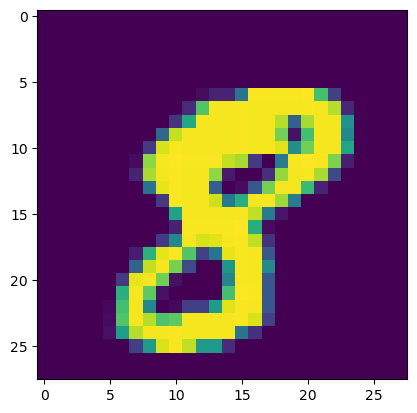

In [4]:
g1= plt.imshow(X[10][:,:,0])
display("LABEL:", y[10])

'LABEL:'

2

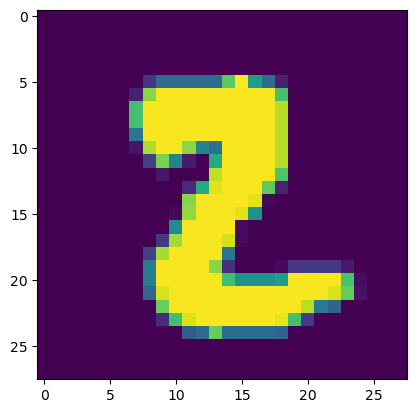

In [5]:
plt.imshow(X[16][:,:,0])
display("LABEL:", y[16])

### Redefinición de los Labels
Como lo que queremos hacer es un clasificador binario que unicamente detecte imagenes con el valor 2, tenemos que modificar los labels para tener unicamente dos valores y=1, cuando la imagen representa un 2 e y=0, cuando la imagen representa cualquier otro digito.

Para ello hacemos uso del potencial de pandas, que nos permite modificar valores de columnas facilmente utilizando condiciones y filtros. Por ejemplo, si quisieramos cambiar el valor de todos los labels que se corresponden con el digito 9 por un valor igual a -1, podemos hacer:

```
y.loc[y==9] = -1
```

Esta linea de codigo buscaria en la variable **y** (que es una pandas Series) todas aquellas filas que contienen el valor 9 y los reemplazaria con un valor igual a -1.

De esta misma forma, podremos modificar nuestro dataset para que contenga dos valores y=1, para todos los labels igual a 2 e y=0 para todos los labels distintos de 2.

#### Ejercicio 2
a) Modificar los valores de **y** para que solo contenga los labels y=1 e y=0.


In [6]:
# Modificar y tal que si la imágen que representa es un 2, su label sea 1,
# y si la imágen que representa no es un 2, su label sea 0
y.loc[y!=2] = 0
y.loc[y==2] = 1

b) Observar la cantidad de ejemplos por cada label, analizando la variable **y**.

In [7]:
y.value_counts().sort_index()

label
0    37823
1     4177
Name: count, dtype: int64

Como vimos anteriormente, para los algoritmos de ML en general suele ser mejor normalizar los datos para que el proceso de aprendizaje sea más efectivo y eficiente.

Para ello normalizamos dividiendo por 255 todos los valores de pixeles que se encuentran en la variable X

In [8]:
X = X / 255.0

En este punto tenemos unicamente dos labels: 
- **0**, para aquellas imagenes que no representan el digito 2
- **1**, para las imagenes que representan el digito 2.

### Creación del modelo con Tensorflow y Keras

A continuación vamos a definir el modelo del clasificador binario. Para ello, veamos como es posible crear redes neuronales utilizando el framework Tensorflow.

Lo primero que tenemos que hacer es importar el modulo de tensorflow

In [9]:
import tensorflow as tf

# Imprimimos la version de tensorflow
display(tf.__version__)

'2.10.0'

En particular vamos a utilizar Keras (tf.keras), que es la API de alto nivel de TensorFlow para construir y entrenar modelos de aprendizaje profundo. 

Keras provee de una serie de clases que nos permiten construir facilmente redes neuronales en una pocas lineas de codigo. Veamos algunas de ellas:

[Sequential](https://keras.io/api/models/sequential/): Esta clase define una secuencia de layers en la red neuronal. Suele utilizarse como contenedor de toda la red y sus layers internas.

[Flatten](https://keras.io/api/layers/reshaping_layers/flatten/): En general las imágenes estan representadas por una matriz de píxeles (en este ejemplo, de 28x28). La clase Flatten simplemente toma esa matriz y la convierte en una matriz unidimensional (1D).

[Dense](https://keras.io/api/layers/core_layers/dense/): La clase Dense define la layer más simple de redes neuronales en donde todas las neuronas se conectan con todas las entradas y todas las salidas.

Recordemos que cada layer de neuronas necesita una [función de activación](https://keras.io/api/layers/activations/) para decirles qué hacer. Hay muchas opciones, pero por ahora solo usaremos la funcion sigmoidea ('sigmoid').
 
Teniendo este conocimiento basico de Keras, la construcción del modelo se define de la siguiente manera:


 
```
model = tf.keras.models.Sequential()
model.add(layer_1)
...
model.add(layer_n)
```



En general, si se trata de imagenes, la primera layer del modelo es de la clase Flatten. Las siguientes layers suelen ser del tipo Dense, con diferentes cantidades de neuronas. 

Recordemos que, como en nuestro caso estamos realizando un clasificador binario, necesitamos que la ultima layer tenga una única neurona.

Ahora que sabemos como construir una red neuronal simple con Keras, vamos a definir un modelo para nuestro problema.


#### Ejercicio 3
a) Crear un modelo de red neuronal con Keras, usando la clase Sequential. Luego, agregarle 3 layers distintas: una layer para convertir las imagenes en una matriz 1D, una layer densa con 128 neuronas y una layer de salida tambien densa con una única neurona.
 
 

In [10]:
# Crear un modelo de red neuronal con Keras, usando la clase Sequential.
model = tf.keras.models.Sequential()

# Agregamos 3 layers distintas: 
# Una para convertir las imágenes en una matriz 1D
model.add(tf.keras.layers.Flatten())
# Una layer densa con 128 neuronas 
model.add(tf.keras.layers.Dense(128, activation='sigmoid'))
# Una layer de salida densa con una única neurona.
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


b) Compile el modelo utilizando el metodo [.compile()](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile). La función de costo que vamos a utilizar es 'binary_crossentropy' y como metrica solo 'accuracy'.

In [11]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'])


**c)** Entrene el modelo utilizando el método [.fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit), con los valores de **X** y de **y**. Setee la cantidad de epochs a 5. 

**Aclaración:** La cantidad de epochs se refiere al paso completo de datos de los entrenamiento a través del modelo. En este ejemplo con 5 pasadas es suficiente.

In [12]:
model.fit(x=X, y=y, epochs=5)

Epoch 1/5
1313/1313 [==============================] - 4s 2ms/step - loss: 0.0837 - accuracy: 0.9748
Epoch 2/5
1313/1313 [==============================] - 3s 2ms/step - loss: 0.0629 - accuracy: 0.9820
Epoch 3/5
1313/1313 [==============================] - 3s 2ms/step - loss: 0.0482 - accuracy: 0.9863
Epoch 4/5
1313/1313 [==============================] - 2s 1ms/step - loss: 0.0389 - accuracy: 0.9889
Epoch 5/5
1313/1313 [==============================] - 2s 1ms/step - loss: 0.0338 - accuracy: 0.9908


**d)** Generar predicciones para el dataset completo (**X**), utilizando el metodo [.predict()](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict).

**Aclaración:** Recordemos que  el metodo .predict() devuelve la probabilidad de que pertenezca a la clase positiva. En este ejemplo, sera la probabilidad de que la imagen sea efectivamente un 2.

In [13]:
predictions = model.predict(X)

1313/1313 [==============================] - 2s 1ms/step


**e)** Imprimir las predicciones generadas por el modelo para las imagenes visualizadas anteriormente (indices 10 y 16). Recordemos que la imagen del indice 10 corresponde al digito 8 y la imagen del indice 16 corresponde al digito 2. En este caso, imprimir el label real y el label estimado por el modelo.

In [14]:
print(f"Para la imágen del índice 10 tenemos la predicción {predictions[10]}. Su valor real es {y[10]}.")
print(f"Para la imágen del índice 16 tenemos la predicción {predictions[16]}. Su valor real es {y[16]}.")

Para la imágen del índice 10 tenemos la predicción [1.1642242e-05]. Su valor real es 0.
Para la imágen del índice 16 tenemos la predicción [0.9664814]. Su valor real es 1.


Finalmente realizamos una evaluación del modelo en el dataset de entrenamiento. 

Tengamos en cuenta que en este ejemplo no dividimos el dataset en dataset de entrenamiento y dataset de testeo porque el objetivo era aprender a construir redes neuronales simples. Es por ello que el accuracy que arroje el metodo [.evaluate()](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate) nos va a decir que tan preciso es el modelo en predecir los labels de los mismos ejemplos con los que fue entrenado. **Para evaluar con mayor precision el rendimiento del modelo deberiamos evaluarlo con un dataset desconocido por el.**


Observar que el metodo .evaluate devuelve un vector con dos valores: el error y el accuracy.

In [15]:
model.evaluate(X, y)

1313/1313 [==============================] - 2s 1ms/step - loss: 0.0304 - accuracy: 0.9915


[0.03037452884018421, 0.9915476441383362]